In [1]:
# Importing libraries
import pandas as pd
import numpy as np

from collections import Counter
from collections import defaultdict

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import ADASYN

from sklearn.utils import shuffle

# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import seaborn as sns
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)

In [2]:
#Explainer
from lime.lime_tabular import LimeTabularExplainer
import shap

c:\Users\User\anaconda3\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\User\anaconda3\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, 

## Data Preprocessing

In [3]:
# reading the clean dataset with only features selected with filter approaches
# the data is also already normalized (min-max) and cubic-transformed
df_all = pd.read_csv('data_UFS_XAI_vocal_channel.csv')

In [4]:
# TRAIN and TEST datasets split (and labels)
targ = 'vocal_channel'
labels = df_all.pop(targ)
df_train, df_test = df_all.loc[:1827,:], df_all.loc[1828:,:]
df_train.head()

frame_count  mfcc_sum  mfcc_q25   sc_mean    sc_q50  mfcc_std_w1  \
0     0.106792  0.591481  0.896695  0.954851  0.927656     0.933467   
1     0.116504  0.592678  0.862466  0.901829  0.799551     0.819130   
2     0.097081  0.602877  0.896088  0.921414  0.911578     0.821121   
3     0.067960  0.635597  0.892183  0.877914  0.841966     0.800603   
4     0.174752  0.523167  0.852104  0.875715  0.733857     0.903958   

   mfcc_max_w1  mfcc_min_w2  mfcc_kur_w2  sc_mean_w2  sc_q50_w2  sc_kur_w2  \
0     0.265192     0.299631     0.438077    0.405315   0.378612   0.087534   
1     0.135787     0.290148     0.457699    0.420190   0.414946   0.051492   
2     0.156563     0.301450     0.540126    0.474156   0.417184   0.060925   
3     0.253886     0.301954     0.590455    0.556900   0.480095   0.052288   
4     0.205817     0.216527     0.419206    0.404362   0.447259   0.130634   

   lag1_skew_w4  mfcc_max_w4  sc_std_w4  
0      0.593791     0.159312   0.268862  
1      0.592731     0.209908   0.268475  
2      0.593133     0.192688   0.299826  
3      0.593420     0.247124   0.247404  
4      0.593473     0.330613   0.299318

In [5]:
# vars to encode
count = 0
try:
    cat_vars = list(df_all.loc[:,'emotion':'sex'].columns)

    # one hot encoding of train df_train and df_test
    df_train = pd.get_dummies(df_train, columns = cat_vars, dtype = np.int8)
    df_test = pd.get_dummies(df_test, columns = cat_vars, dtype = np.int8)
    count = 1
except:
    pass
# Label Encoder
le = LabelEncoder()
labels = le.fit_transform(labels)
label_encoder_name_mapping = dict(zip(le.classes_,
                                         le.transform(le.classes_)))
print("Mapping of Label Encoded Classes: ", label_encoder_name_mapping, sep="\n")

# splitting the labels in train and test
labels_train, labels_test = labels[:1828], labels[1828:]
df_train.insert(0,str(targ),labels_train)
df_test.insert(0,str(targ),labels_test)

Mapping of Label Encoded Classes: 
{'song': 0, 'speech': 1}


In [6]:
# checking the shapes
print('train and test dfs shape: ', df_train.shape, df_test.shape)
print('train and test labels shape: ', labels_train.shape, labels_test.shape)
df_train.head()

train and test dfs shape:  (1828, 16) (624, 16)
train and test labels shape:  (1828,) (624,)


vocal_channel  frame_count  mfcc_sum  mfcc_q25   sc_mean    sc_q50  \
0              1     0.106792  0.591481  0.896695  0.954851  0.927656   
1              1     0.116504  0.592678  0.862466  0.901829  0.799551   
2              1     0.097081  0.602877  0.896088  0.921414  0.911578   
3              1     0.067960  0.635597  0.892183  0.877914  0.841966   
4              1     0.174752  0.523167  0.852104  0.875715  0.733857   

   mfcc_std_w1  mfcc_max_w1  mfcc_min_w2  mfcc_kur_w2  sc_mean_w2  sc_q50_w2  \
0     0.933467     0.265192     0.299631     0.438077    0.405315   0.378612   
1     0.819130     0.135787     0.290148     0.457699    0.420190   0.414946   
2     0.821121     0.156563     0.301450     0.540126    0.474156   0.417184   
3     0.800603     0.253886     0.301954     0.590455    0.556900   0.480095   
4     0.903958     0.205817     0.216527     0.419206    0.404362   0.447259   

   sc_kur_w2  lag1_skew_w4  mfcc_max_w4  sc_std_w4  
0   0.087534      0.593791     0.159312   0.268862  
1   0.051492      0.592731     0.209908   0.268475  
2   0.060925      0.593133     0.192688   0.299826  
3   0.052288      0.593420     0.247124   0.247404  
4   0.130634      0.593473     0.330613   0.299318

In [7]:
# if we want to oversample the data
def apply_ADASYN(X, y):
    # oversampling the minority class for balanced learning
    from imblearn.over_sampling import ADASYN
    ada = ADASYN(random_state = 42)
    X, y = ada.fit_resample(X, y)
    print('resampled training set: ', X.shape, y.shape)
    print('target var. class frequencies:')
    print(Counter(y))
    return X, y

In [8]:
# converting df_train and df_test into np matrices and arrays
X, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,1:].values
y, y_test = df_train.loc[:,targ].values, df_test.loc[:,targ].values

# shuffling train and val concatenation to remove potential pattern bias
X, y  = shuffle(X, y, random_state=42)

In [9]:
# shuffling also the test set for explainability tasks
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [10]:
# shuffled dataset
df_train = pd.concat([pd.DataFrame(y.astype(np.int8).T, columns = [targ]), pd.DataFrame(X, columns = df_train.columns[1:])], axis=1)
df_test = pd.concat([pd.DataFrame(y_test.astype(np.int8).T, columns = [targ]), pd.DataFrame(X_test, columns = df_test.columns[1:])], axis=1)
if count == 1:
    for c in df_train.columns[-16:]:
        df_train[c] = df_train[c].astype(int)
        df_test[c] = df_test[c].astype(int)
else:
    pass
df_train.head()

vocal_channel  frame_count  mfcc_sum  mfcc_q25   sc_mean    sc_q50  \
0              1     0.077671  0.730182  0.594289  0.478477  0.286069   
1              1     0.067960  0.618434  0.935443  0.873740  0.879673   
2              1     0.194175  0.534558  0.571132  0.652626  0.575751   
3              0     0.320389  0.581329  0.614202  0.428600  0.301606   
4              1     0.349511  0.633329  0.684801  0.607888  0.412018   

   mfcc_std_w1  mfcc_max_w1  mfcc_min_w2  mfcc_kur_w2  sc_mean_w2  sc_q50_w2  \
0     0.692327     0.357807     0.363602     0.486988    0.423700   0.531248   
1     0.786514     0.101965     0.203571     0.498155    0.515292   0.495542   
2     0.836205     0.371954     0.341467     0.445654    0.472851   0.340860   
3     0.584868     0.327194     0.581077     0.195234    0.123660   0.193337   
4     0.874089     0.100418     0.588569     0.509987    0.381461   0.478280   

   sc_kur_w2  lag1_skew_w4  mfcc_max_w4  sc_std_w4  
0   0.055587      0.575032     0.510006   0.203119  
1   0.091553      0.593971     0.155138   0.203339  
2   0.015227      0.593263     0.388661   0.213681  
3   0.671691      0.640508     0.659897   0.481607  
4   0.666769      0.596792     0.756758   0.339454

In [11]:
df_test.head()

vocal_channel  frame_count  mfcc_sum  mfcc_q25   sc_mean    sc_q50  \
0              1     0.097087  0.666993  0.671625  0.760885  0.762208   
1              0     0.582524  0.475423  0.570608  0.454802  0.121367   
2              1     0.330094  0.617907  0.812397  0.518201  0.493184   
3              1     0.320389  0.588715  0.819283  0.595503  0.510563   
4              0     0.456309  0.513625  0.535264  0.467352  0.130756   

   mfcc_std_w1  mfcc_max_w1  mfcc_min_w2  mfcc_kur_w2  sc_mean_w2  sc_q50_w2  \
0     0.866706     0.177414     0.441782     0.746328    0.479823   0.478758   
1     0.515650     0.614658     0.582119     0.196170    0.071483   0.135100   
2     0.572168     0.349778     0.602526     0.169564    0.109683   0.057541   
3     0.635671     0.370302     0.612072     0.170230    0.171211   0.157989   
4     0.481621     0.751771     0.613718     0.148324    0.096157   0.121127   

   sc_kur_w2  lag1_skew_w4  mfcc_max_w4  sc_std_w4  
0   0.033874      0.592256     0.186898   0.153692  
1   0.814755      0.672048     0.678296   0.700671  
2   0.503918      0.599848     0.653404   0.418390  
3   0.113170      0.585180     0.678825   0.550476  
4   0.808770      0.686747     0.703858   0.656943

RUN THE CODE BLOCK BELOW FOR OVERSAMPLED VERSION (Only Classification)

In [12]:
# adasyn oversampling
#X, y = apply_ADASYN(X,y)

In [13]:
# split train/val = 80/20
split_idx = df_train.shape[0]-int(df_train.shape[0]*0.2)
X_train, X_val = X[:split_idx,:], X[split_idx:,:]
y_train, y_val = y[:split_idx], y[split_idx:]

print('X_train: ', X_train.shape, 'y_train: ', y_train.shape)
print('X_val: ', X_val.shape, 'y_val: ', y_val.shape)
print()

print('target variable classes frequencies:')
print()
print('training set: ',Counter(y_train))
print('validation set: ',Counter(y_val))
print('test set: ',Counter(labels_test))

X_train:  (1463, 15) y_train:  (1463,)
X_val:  (365, 15) y_val:  (365,)

target variable classes frequencies:

training set:  Counter({1: 854, 0: 609})
validation set:  Counter({1: 226, 0: 139})
test set:  Counter({1: 360, 0: 264})


In [14]:
np.random.seed(23)  # for reproducibility

#### Libs for Neural Networks

In [15]:
import tensorflow as tf

from tensorflow.keras import utils, losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import LearningRateScheduler, History

In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  0


[]

In [17]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9193533293729790563
xla_global_id: -1
]


## Building a Neural Network to classify the vocal channel

In [18]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning

In [19]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### NN building function

In [20]:
def create_nn(units):
    tf.keras.backend.clear_session()
    model = Sequential()
    
    n_feat = X.shape[1]
    # input layer (input_dim) and first hidden layer
    model.add(Dense(units[0], input_dim=n_feat, activation='relu', kernel_initializer='random_uniform'))
    # other hidden layers (if we specify)
    for n in range(1, len(units)-1):
        model.add(Dense(units[n], activation='relu', kernel_initializer='random_uniform'))
    # output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform'))

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
    return model

### Plotting function: loss and accuracy vs epochs

In [21]:
def plot_trainVal(model_history, name='Model'):
    tr_loss, std_tr_loss = round(np.mean(model_history.history['loss']), 3), round(np.std(model_history.history['loss']), 3)
    
    val_loss, std_val_loss = round(np.mean(model_history.history['val_loss']), 3), round(np.std(model_history.history['val_loss']), 3)
    

    tr_acc, max_tr_acc, std_tr_acc = round(np.mean(model_history.history['acc']), 3), \
                                     round(np.max(model_history.history['acc']), 3), \
                                     round(np.std(model_history.history['acc']), 3)
                                    
    val_acc, max_val_acc, std_val_acc  = round(np.mean(model_history.history['val_acc']), 3), \
                                        round(np.max(model_history.history['val_acc']), 3), \
                                        round(np.std(model_history.history['val_acc']), 3)
    

    # plotting the loss function
    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    ax.plot(model_history.history['loss'], 'r', linewidth = 1.5, label=f'mean Training Loss: {tr_loss} +/- {std_tr_loss}')
    ax.plot(model_history.history['val_loss'], 'b', linewidth = 1.5,label=f'mean Validation Loss: {val_loss} +/- {std_val_loss}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Crossentropy')
    plt.title(f'Loss of {name}')
    ax.legend()
    ax.tick_params()

    # doing the same for the accuracy
    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    ax.plot(model_history.history['acc'], 'r', linewidth = 1.5, label=f'mean Training Accuracy: {tr_acc} +/- {std_tr_acc}\nmax: {max_tr_acc}')
    ax.plot(model_history.history['val_acc'], 'b', linewidth = 1.5,label=f'mean Validation Accuracy: {val_acc} +/- {std_val_acc}\nmax: {max_val_acc}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    plt.title(f'Accuracy of {name}')
    ax.legend()
    ax.tick_params()

In [22]:
# all the classes of the target variable
classes = df_train[targ].unique()
classes

array([1, 0], dtype=int8)

### Trying an ANN

In [23]:
# choose a NN structure: hidden layers + output layer (multiclass -> 8 nodes)
layers = [16,2]

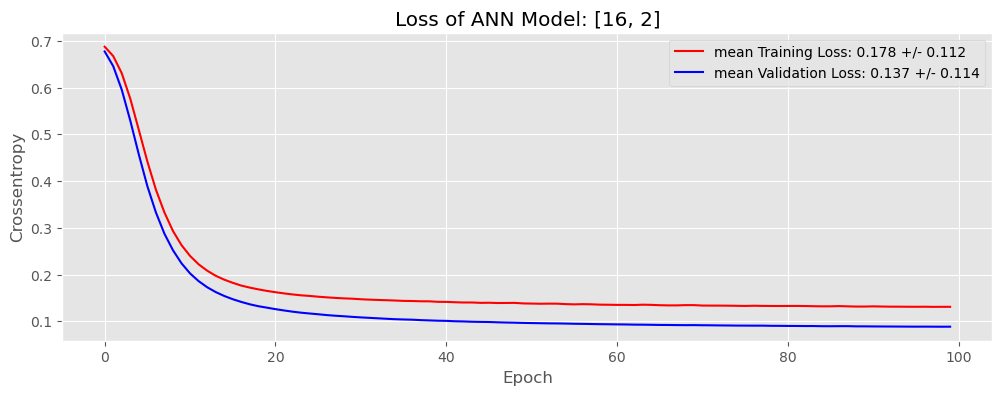

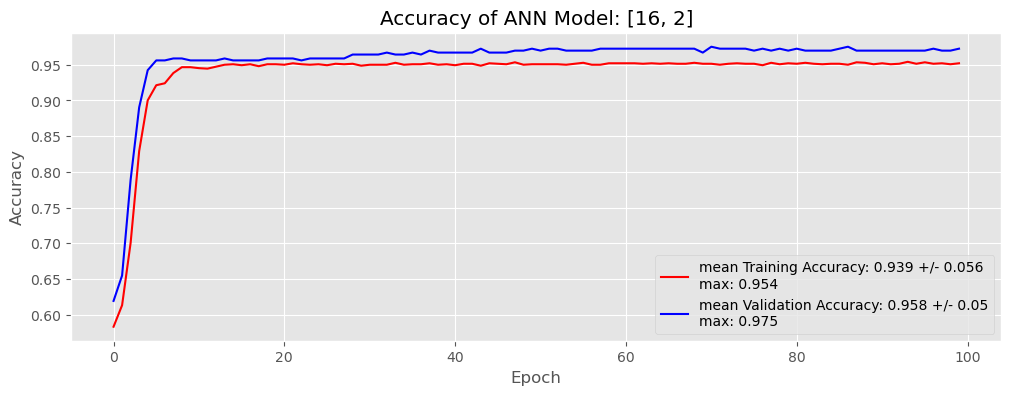

In [24]:
tf.keras.backend.clear_session()
model_normal = create_nn(layers)
history_normal = model_normal.fit(X_train, y_train, validation_data=(X_val, y_val),
                                  batch_size = 50, epochs = 100, verbose = 0)
plot_trainVal(history_normal, f'ANN Model: {layers}')

### Hyperparameter Tuning

In [25]:
# return best estimator from gridsearch
def rs_best_estimator(clf, param_grid, X, y, cv=5):
    rs = RandomizedSearchCV(clf, param_distributions=param_grid, cv=cv, scoring = 'accuracy')
    rs.fit(X, y)
    print(f'best estimator: {rs.best_estimator_}')
    print(f'best score: {rs.best_score_}')
    print(f'best parameters: {rs.best_params_}')       
    return rs

In [26]:
# function needed to perform gridsearch with kerasClassifier wrapper
def nn_rs(layers, activation):
    tf.keras.backend.clear_session()
    model = Sequential()
    
    n_feat = X.shape[1]

    for i,nodes in enumerate(layers):
        # input layer (input_dim) and first hidden layer
        if i == 0:
            model.add(Dense(nodes, input_dim=n_feat, kernel_initializer='uniform'))
            model.add(Activation(activation))
        else:
            # other hidden layers (if we specify)
            model.add(Dense(nodes, kernel_initializer='uniform'))
            model.add(Activation(activation))
    # output layer
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('sigmoid'))

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
    return model

In [27]:
# DROPOUT REGULARIZATION
def nn_dropout_rs(layers, activation):
    tf.keras.backend.clear_session()
    model = Sequential()

    dropout = 0.3
    n_feat = X.shape[1]
    
    for i,nodes in enumerate(layers):
        # input layer (input_dim) and first hidden layer
        if i == 0:
            model.add(Dense(nodes, input_dim=n_feat, kernel_initializer='uniform'))
            model.add(Activation(activation))
            #model.add(Dropout(dropout))
        else:
            # other hidden layers (if we specify)
            model.add(Dense(nodes, kernel_initializer='uniform'))
            model.add(Activation(activation))
            model.add(Dropout(dropout))
    # output layer
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('sigmoid'))

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
    return model

In [28]:
# tuning layers, activations, batch sizes and epochs first, then optimizer

layers1= [[4,8],[16,8],[32,8],[8,8],[4,16],[128, 64], 
        [128, 16], [128, 128], [16, 64], [8, 8], [32]]
#
layers2=[[256,128,64,32],[256,64,32],[128,64,32],[256,128,64,32],[256,128,32],
        [64,32],[64,32,16],[64,128,32],[256,128,32,64],[32,32,32],
        [8,8,8],[32,32,32], [64,64,64]]
#
#layers3 = [[128, 16, 8], [128, 16, 16], [128, 64], [128, 64, 16], [128, 64, 8],
#           [128, 16, 4], [128, 4, 16], [128, 8, 4], [128, 4]]
#
activations = ['sigmoid','relu','tanh', 'softmax']

In [29]:
param_grid1 = dict(layers=layers1, activation=activations, batch_size=[60,70,80,90,100], epochs=[50,70,100,120,150])

### NN

In [30]:
import random
from scikeras.wrappers import KerasClassifier

#tf.keras.backend.clear_session()
#ann_rs = KerasClassifier(model = nn_rs, verbose = 0, 
#                         layers = [20], 
#                         activation = 'relu',random_state=23)
#
#rs_results = rs_best_estimator(ann_rs, param_grid1, X, y)
#rs_results

	best estimator: KerasClassifier(
		model=<function nn_rs at 0x0000029CE447D280>
		build_fn=None
		warm_start=False
		random_state=23
		optimizer=rmsprop
		loss=None
		metrics=None
		batch_size=80
		validation_batch_size=None
		verbose=0
		callbacks=None
		validation_split=0.0
		shuffle=True
		run_eagerly=False
		epochs=100
		layers=[128, 64]
		activation=relu
		class_weight=None
	)
	best score: 0.9814027996107495
	best parameters: {'layers': [128, 64], 'epochs': 100, 'batch_size': 80, 'activation': 'relu'}

### Dropout NN

In [31]:
#tf.keras.backend.clear_session()
#ann_dropout_rs = KerasClassifier(model = nn_dropout_rs, verbose = 0, 
#                         layers = [20], 
#                         activation = activations,random_state=23)
#
#rs_results_dropout = rs_best_estimator(ann_dropout_rs, param_grid1, X, y)
#rs_results_dropout

    best estimator: KerasClassifier(
    	model=<function nn_dropout_rs at 0x0000029FCDAC6280>
    	build_fn=None
    	warm_start=False
    	random_state=23
    	optimizer=rmsprop
    	loss=None
    	metrics=None
    	batch_size=80
    	validation_batch_size=None
    	verbose=0
    	callbacks=None
    	validation_split=0.0
    	shuffle=True
    	run_eagerly=False
    	epochs=100
    	layers=[128, 64]
    	activation=relu
    	class_weight=None
    )
    best score: 0.98085485440527
    best parameters: {'layers': [128, 64], 'epochs': 100, 'batch_size': 80, 'activation': 'relu'}

## Tuned ANN models
### These final configurations are the best ones found over all the variants!!!

In [32]:
# TUNED
def tuned_nn():
    tf.keras.backend.clear_session()
    model = Sequential()
    # choose initialization (normal, uniform, random_normal, random_uniform, glorot)
    weights = 'uniform'

    n_feat = X.shape[1]
    # input layer (input_dim) and first hidden layer
    model.add(Dense(128, input_dim=n_feat, activation='relu', kernel_initializer=weights))
    # other hidden layers (if we specify)
    model.add(Dense(64, activation='relu', kernel_initializer=weights))
    # output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=weights))
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])
    return model

In [33]:
# TUNED DROPOUT REGULARIZATION
def tuned_nn_dropout(dropout = 0.3):
    tf.keras.backend.clear_session()
    model = Sequential()
    # choose initialization (normal, uniform, random_normal, random_uniform, glorot)
    weights = 'uniform'

    n_feat = X.shape[1]
    # input layer (input_dim) and first hidden layer
    model.add(Dense(128, input_dim=n_feat, activation='relu', kernel_initializer=weights))
    # other hidden layers (if we specify)
    model.add(Dense(64, activation='relu', kernel_initializer=weights))
    model.add(Dropout(dropout))
    # output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=weights))
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])
    return model

## Plotting train/val loss and train/val accuracy

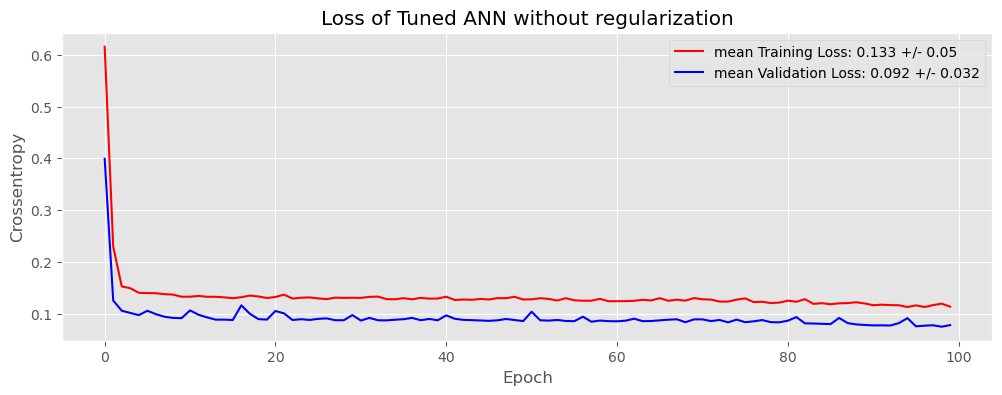

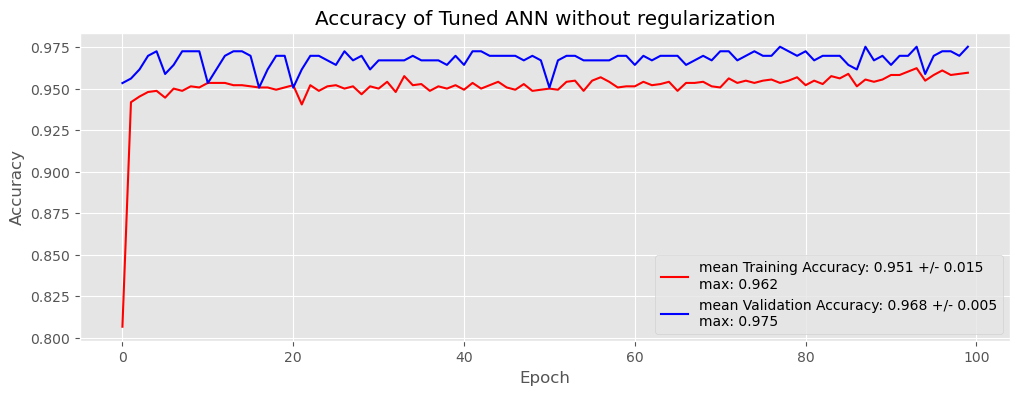

In [34]:
# testing the tuned NN variants
tf.keras.backend.clear_session()
ANN_normal = tuned_nn()
history_normal = ANN_normal.fit(X_train, y_train, validation_data=(X_val, y_val),
                              epochs=100, batch_size = 30, verbose = 0)
plot_trainVal(history_normal, 'Tuned ANN without regularization')

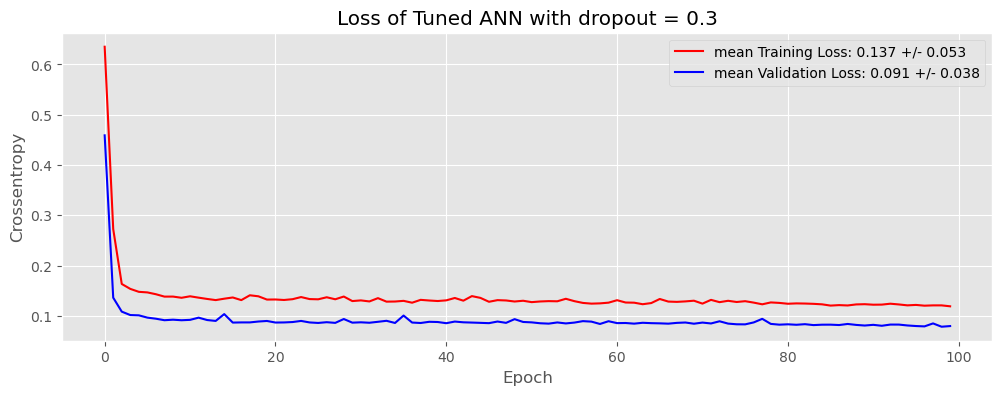

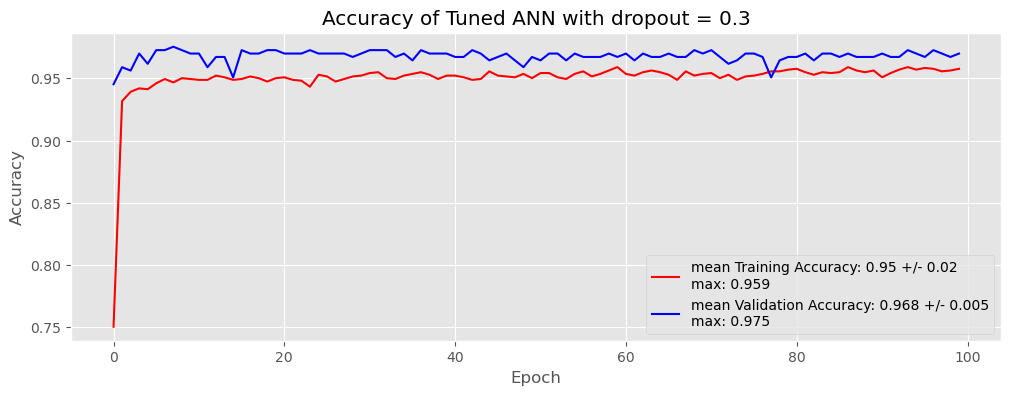

In [35]:
# testing the tuned NN variants
tf.keras.backend.clear_session()
ANN_dropout = tuned_nn_dropout()
history_dropout = ANN_dropout.fit(X_train, y_train, validation_data=(X_val, y_val),
                              epochs=100, batch_size = 30, verbose = 0)
plot_trainVal(history_dropout, 'Tuned ANN with dropout = 0.3')

## Testing the tuned NN variants

In [36]:
warnings.filterwarnings('ignore')

In [37]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall, plot_precision_recall_curve
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import multilabel_confusion_matrix

In [38]:
rand_state = 100

### Normal NN

20/20 [==============================] - 0s 638us/step
Accuracy: 0.9230769230769231

F1-score: [0.91549296 0.92941176]

              precision    recall  f1-score   support

        song       0.86      0.98      0.92       264
      speech       0.99      0.88      0.93       360

    accuracy                           0.92       624
   macro avg       0.92      0.93      0.92       624
weighted avg       0.93      0.92      0.92       624

20/20 [==============================] - 0s 643us/step

AUC: 0.9858270202020202


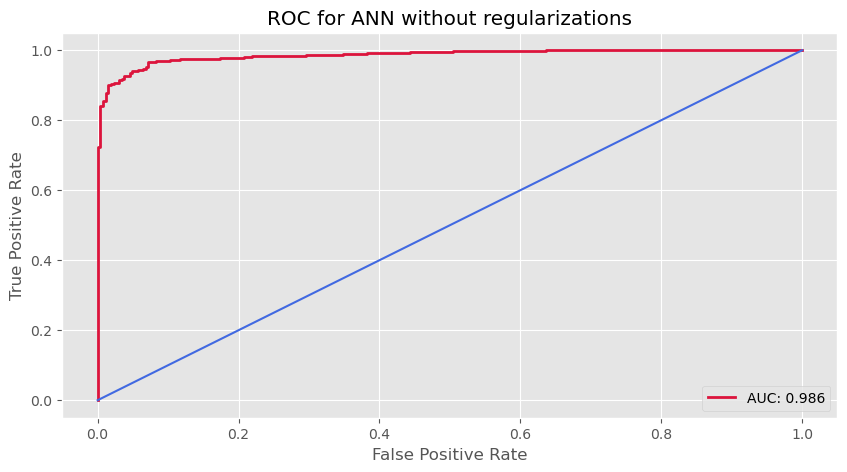

In [39]:
tf.keras.backend.clear_session()
ANN_normal = KerasClassifier(tuned_nn, random_state = rand_state)
ANN_normal = ANN_normal.fit(X, y, epochs=100, batch_size = 30, verbose = 0)

y_hat_normal = ANN_normal.predict(X_test).ravel()
acc_score_normal = accuracy_score(y_test, y_hat_normal)
f1_normal = f1_score(y_test, y_hat_normal, average=None)

print(f'Accuracy: {acc_score_normal}')
print()
print(f'F1-score: {f1_normal}')
print()
print(classification_report(y_test, y_hat_normal, target_names=label_encoder_name_mapping))

y_test_pred_proba = ANN_normal.predict_proba(X_test)
y_proba_ann = y_test_pred_proba[:,1]


y_test_dec = le.inverse_transform(y_test)
fpr, tpr, threshold = roc_curve(y_test, y_proba_ann)
roc_auc = auc(fpr, tpr)
print()
print(f'AUC: {roc_auc}')

plt.figure(figsize = (10,5))
plt.title(f'ROC for ANN without regularizations')
plt.plot(fpr, tpr, label = f'AUC: {round(roc_auc,3)}', lw = 2, color = 'crimson')
plt.legend()
plt.plot([0, 1], [0, 1], color = 'royalblue')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Dropout NN

20/20 [==============================] - 0s 571us/step
Accuracy: 0.9342948717948718

F1-score: [0.92717584 0.94014599]

              precision    recall  f1-score   support

        song       0.87      0.99      0.93       264
      speech       0.99      0.89      0.94       360

    accuracy                           0.93       624
   macro avg       0.93      0.94      0.93       624
weighted avg       0.94      0.93      0.93       624

20/20 [==============================] - 0s 547us/step

AUC: 0.9877630471380471


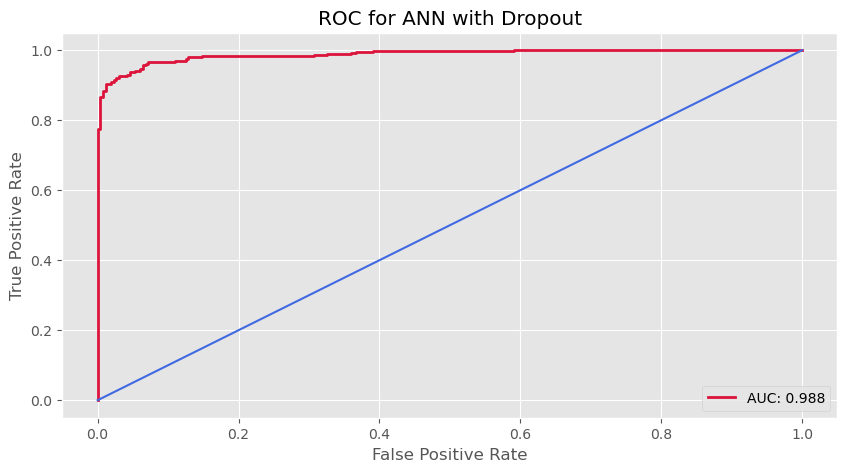

In [40]:
tf.keras.backend.clear_session()
ANN_dropout = KerasClassifier(tuned_nn_dropout(0.3), random_state = rand_state)
ANN_dropout = ANN_dropout.fit(X, y, epochs=100, batch_size = 30, verbose = 0)

y_hat_dropout = ANN_dropout.predict(X_test).ravel()
acc_score_dropout = accuracy_score(y_test, y_hat_dropout)
f1_dropout = f1_score(y_test, y_hat_dropout, average=None)

print(f'Accuracy: {acc_score_dropout}')
print()
print(f'F1-score: {f1_dropout}')
print()
print(classification_report(y_test, y_hat_dropout, target_names=label_encoder_name_mapping))

y_test_pred_proba = ANN_dropout.predict_proba(X_test)
y_proba_ann_dropout = y_test_pred_proba[:,1]


y_test_dec = le.inverse_transform(y_test)
fpr, tpr, threshold = roc_curve(y_test, y_proba_ann_dropout)
roc_auc = auc(fpr, tpr)
print()
print(f'AUC: {roc_auc}')

plt.figure(figsize = (10,5))
plt.title(f'ROC for ANN with Dropout')
plt.plot(fpr, tpr, label = f'AUC: {round(roc_auc,3)}', lw = 2, color = 'crimson')
plt.legend()
plt.plot([0, 1], [0, 1], color = 'royalblue')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Explainability

In [41]:
import matplotlib.patches as mpatches

In [42]:
df_test.head()

vocal_channel  frame_count  mfcc_sum  mfcc_q25   sc_mean    sc_q50  \
0              1     0.097087  0.666993  0.671625  0.760885  0.762208   
1              0     0.582524  0.475423  0.570608  0.454802  0.121367   
2              1     0.330094  0.617907  0.812397  0.518201  0.493184   
3              1     0.320389  0.588715  0.819283  0.595503  0.510563   
4              0     0.456309  0.513625  0.535264  0.467352  0.130756   

   mfcc_std_w1  mfcc_max_w1  mfcc_min_w2  mfcc_kur_w2  sc_mean_w2  sc_q50_w2  \
0     0.866706     0.177414     0.441782     0.746328    0.479823   0.478758   
1     0.515650     0.614658     0.582119     0.196170    0.071483   0.135100   
2     0.572168     0.349778     0.602526     0.169564    0.109683   0.057541   
3     0.635671     0.370302     0.612072     0.170230    0.171211   0.157989   
4     0.481621     0.751771     0.613718     0.148324    0.096157   0.121127   

   sc_kur_w2  lag1_skew_w4  mfcc_max_w4  sc_std_w4  
0   0.033874      0.592256     0.186898   0.153692  
1   0.814755      0.672048     0.678296   0.700671  
2   0.503918      0.599848     0.653404   0.418390  
3   0.113170      0.585180     0.678825   0.550476  
4   0.808770      0.686747     0.703858   0.656943

In [43]:
# selecting one record for each variable
speech_idx = 9
song_idx = 13

# setting parameters
class_names = ['song','speech']
feature_names = list(df_train.columns[1:])

In [44]:
# simply changing names to make them easier to use
y_pred_ann, y_pred_ann_do = y_hat_normal.copy(), y_hat_dropout.copy()
y_proba_ann, y_proba_ann_do = y_proba_ann.copy(), y_proba_ann_dropout.copy()

## Global XAI

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

### TREPAN (sort of approximation of what the real algorithm does)

In [46]:
# instanciating the decision tree only used as explainer (y_pred instead of y_test)
dt_explainer = DecisionTreeClassifier(max_depth=3, min_samples_leaf = 30, min_samples_split = 100)
dt_explainer.fit(X_test, y_pred_ann)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, min_samples_split=100)

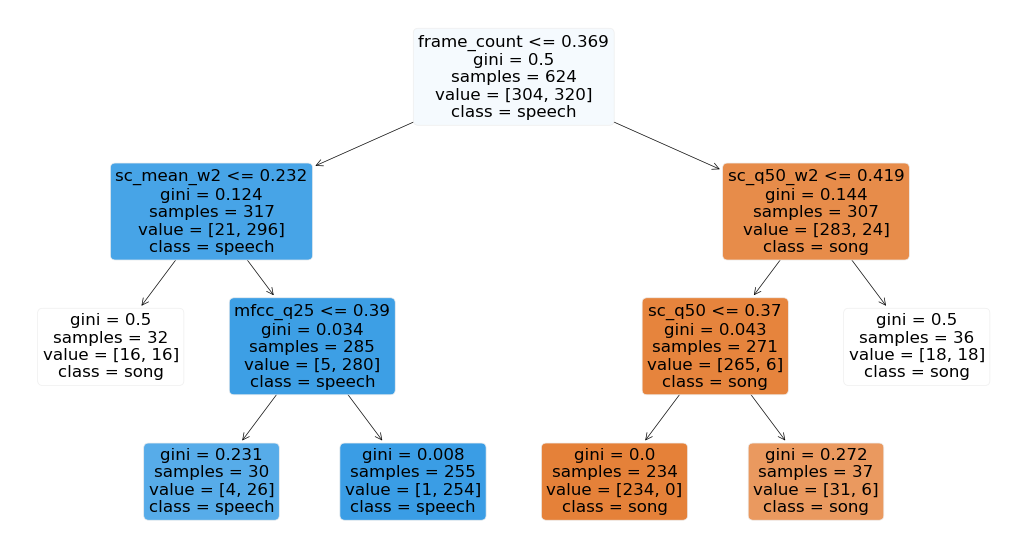

In [47]:
# decision tree that should replicate in some way 
# what the neural network does to assign a label to a record
plt.figure(figsize=(13, 7))
plot_tree(dt_explainer, 
          feature_names = feature_names, 
          class_names = class_names, 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=3)
plt.show()

## Local XAI

### LIME

In [48]:
# instanciating the LIME explainer
lime_explainer = LimeTabularExplainer(X_test, feature_names=feature_names, class_names = class_names, discretize_continuous=False)#,categorical_features=categorical_features,categorical_names=categorical_names)

In [49]:
# song explaination
exp_song = lime_explainer.explain_instance(X_test[song_idx], ANN_normal.predict_proba)
exp_speech = lime_explainer.explain_instance(X_test[speech_idx], ANN_normal.predict_proba)


157/157 [==============================] - 0s 590us/step


#### Song explaining

[('frame_count', -0.21015404407928387), ('mfcc_q25', 0.1540534595349602), ('mfcc_kur_w2', 0.12110804555977259), ('sc_mean_w2', 0.11564207051132017), ('sc_std_w4', -0.09370910975447781), ('sc_mean', 0.08825690022274531), ('sc_q50_w2', 0.08488728042639414), ('sc_kur_w2', -0.06665940147490022), ('mfcc_min_w2', -0.06076613216147932), ('sc_q50', 0.043412678127333564)]


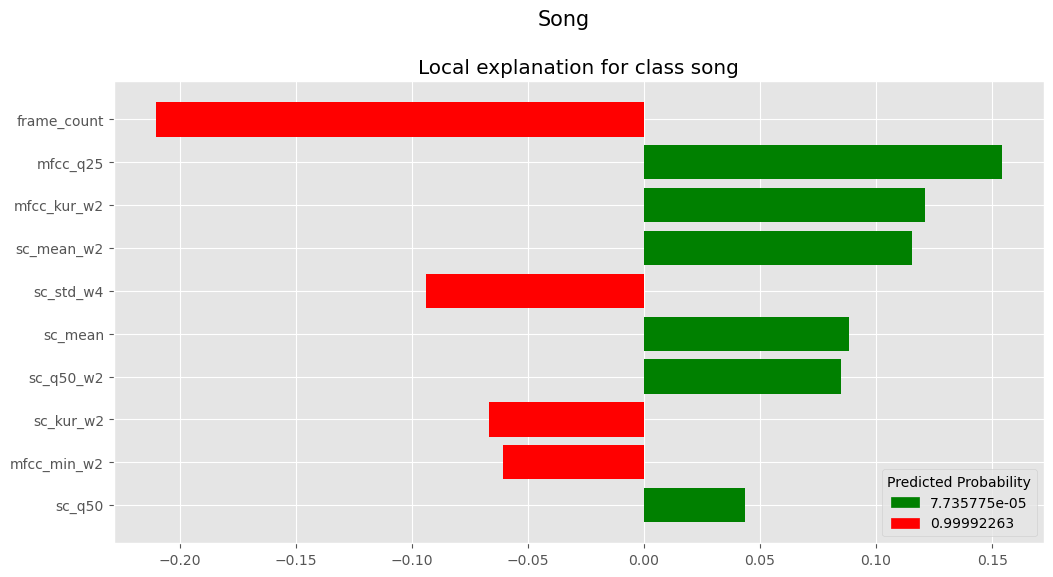

In [50]:
# results for this song record
print(exp_song.as_list())
exp_song.show_in_notebook()
for i in range(1):
    exp_song.as_pyplot_figure()
    plt.title('Local explanation for class song')
    plt.suptitle('Song', y=1, fontsize=15)
    red_patch = mpatches.Patch(color='red', label='0.99992263')
    green_patch = mpatches.Patch(color='green', label='7.735775e-05')
    plt.legend(handles=[green_patch, red_patch], loc='lower right', title='Predicted Probability')

In [51]:
# predict proba for this song record
for el in ANN_normal.predict_proba(X_test)[song_idx]:
    print(el)

 1/20 [>.............................] - ETA: 0s

20/20 [==============================] - 0s 970us/step
0.9993202
0.0006797684


#### Speech explaining

[('mfcc_q25', 0.14975663235388928), ('mfcc_kur_w2', 0.1080567631317086), ('sc_mean_w2', 0.09979916880008094), ('sc_std_w4', -0.09089046131881354), ('sc_mean', 0.0904746439540386), ('sc_q50_w2', 0.07547526500301086), ('sc_kur_w2', -0.05936267107112557), ('mfcc_min_w2', -0.04673033447657361), ('mfcc_sum', 0.03674636557768615), ('mfcc_std_w1', -0.03010281454184951)]


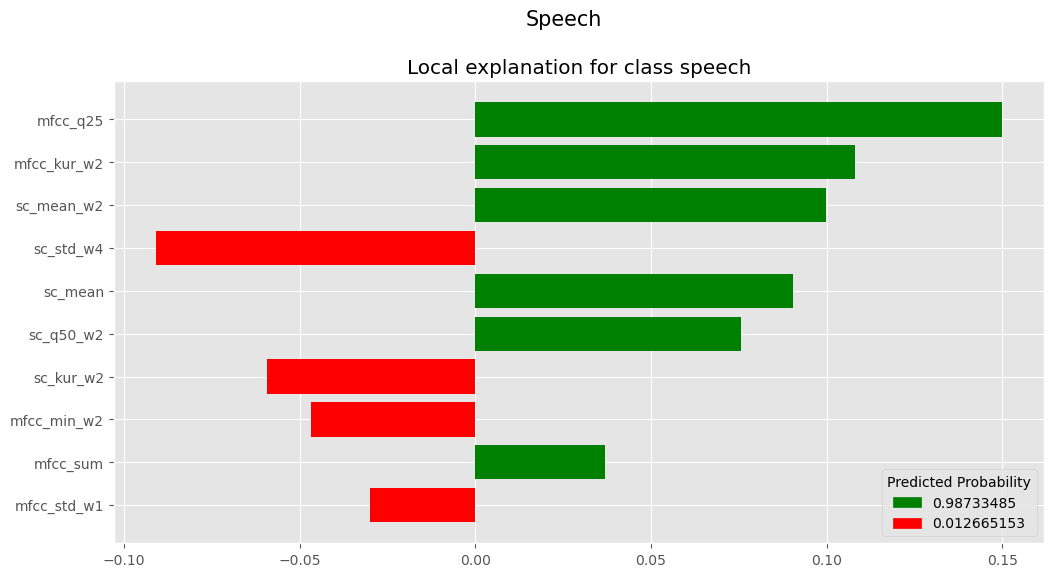

In [52]:
# results for this speech record
print(exp_speech.as_list())
exp_speech.show_in_notebook()
for i in range(1):
    exp_speech.as_pyplot_figure()
    plt.title('Local explanation for class speech')
    plt.suptitle('Speech', y=1, fontsize=15)
    red_patch = mpatches.Patch(color='red', label='0.012665153')   
    green_patch = mpatches.Patch(color='green', label='0.98733485')
    plt.legend(handles=[green_patch, red_patch], loc='lower right', title='Predicted Probability')

In [53]:
# predict proba for this speech record
for el in ANN_normal.predict_proba(X_test)[speech_idx]:
    print(el)

20/20 [==============================] - 0s 525us/step
0.034659147
0.96534085


### SHAP

In [54]:
features = list(df_train.columns[1:])
features

['frame_count',
 'mfcc_sum',
 'mfcc_q25',
 'sc_mean',
 'sc_q50',
 'mfcc_std_w1',
 'mfcc_max_w1',
 'mfcc_min_w2',
 'mfcc_kur_w2',
 'sc_mean_w2',
 'sc_q50_w2',
 'sc_kur_w2',
 'lag1_skew_w4',
 'mfcc_max_w4',
 'sc_std_w4']

In [55]:
from sklearn.neural_network import MLPClassifier
import shap

In [56]:
# instanciating a new ANN classifier since 
# the Keras one could not be explained with SHAP
ANN = MLPClassifier(activation='relu', learning_rate = 'constant', hidden_layer_sizes=(128,64,), max_iter=100,batch_size = 80, random_state=42)

ANN.fit(X, y)

y_pred = ANN.predict(X_test)

y_score = ANN.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

print('ROC AUC {}'.format(roc_auc))
print('Accuracy {}'.format(accuracy_score(y_test, y_pred)))
print('F1-score {}'.format(f1_score(y_test, y_pred, average=None)))
print(classification_report(y_test, y_pred))

ROC AUC 0.9892992424242424
Accuracy 0.9230769230769231
F1-score [0.91549296 0.92941176]
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       264
           1       0.99      0.88      0.93       360

    accuracy                           0.92       624
   macro avg       0.92      0.93      0.92       624
weighted avg       0.93      0.92      0.92       624



In [57]:
shap.initjs()

In [58]:
def bb_predict_proba(X, clf):
    return clf.predict_proba(X)

f = lambda x: bb_predict_proba(x, ANN)[:, 1]

#med = np.median(X_test, axis=0).reshape((1, X_test.shape[1]))

shap_explainer = shap.KernelExplainer(f, X_test[:100,:])
     

### Single record

In [59]:
# shap explainer on single speech record
shap_values_single = shap_explainer.shap_values(X_test[speech_idx,:], nsamples=1000)

shap.force_plot(shap_explainer.expected_value, shap_values_single, features=X_test[speech_idx,:])

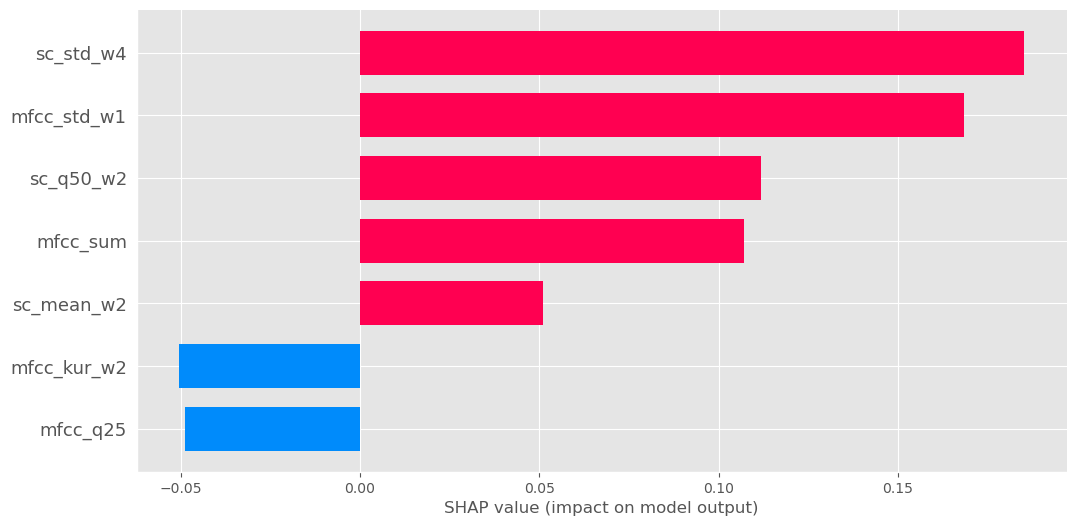

In [60]:
# shap bar plot
shap.bar_plot(shap_values_single, features=None, feature_names=features, show=True)

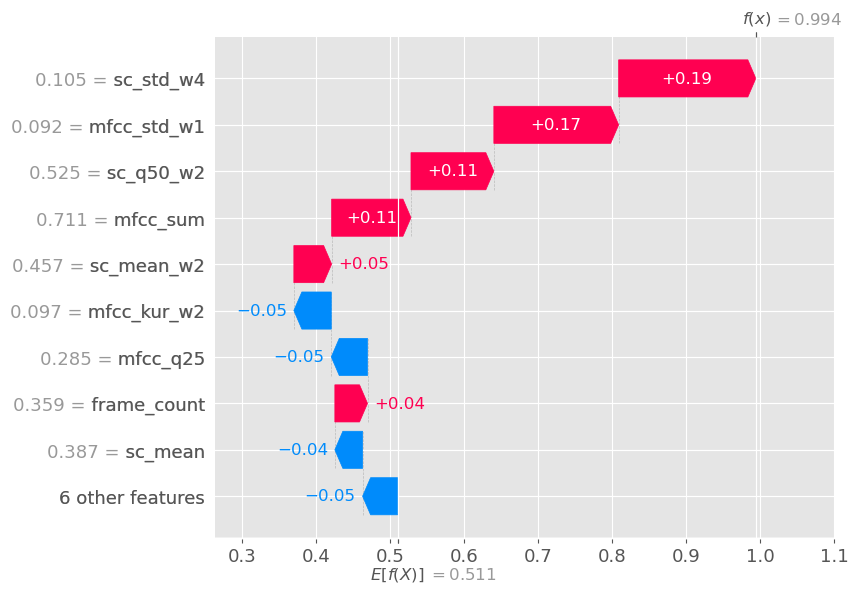

In [61]:
# waterfall plot of shap results
shap.waterfall_plot(shap.Explanation(values=shap_values_single, 
                                         base_values=shap_explainer.expected_value, 
                                         data=X_test[speech_idx],
                                         feature_names=features))

## Multiple records

In [62]:
# shap explainer on a certain number of records
shap_values = shap_explainer.shap_values(X_test[:100,:], nsamples=1000)

shap.force_plot(shap_explainer.expected_value, shap_values, X_test[:100,:], feature_names = features)

  0%|          | 0/100 [00:00<?, ?it/s]

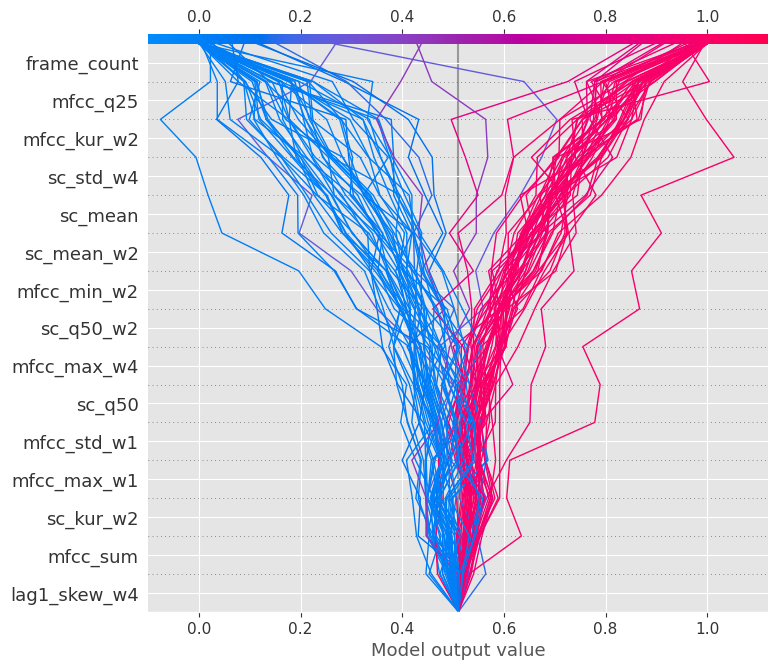

In [63]:
# decision plot for shap explainer on the records
r = shap.decision_plot(shap_explainer.expected_value, shap_values, df_train.columns[1:], return_objects=True)